In [1]:
#Imports
from local_lib.ManualNeuralNetwork.lmnn.model_gpu import lmnn
from local_lib.ManualNeuralNetwork.lmnn.layers.dense_gpu import DenseGpuLayer
from local_lib.ManualNeuralNetwork.lmnn.layers.dropout_gpu import DropoutGpuLayer
from local_lib.ManualNeuralNetwork.lmnn.layers.output_gpu import OutputGpuLayer
from local_lib.ManualNeuralNetwork.lmnn.activations.sigmoid_gpu import SigmoidGpuActivation
from local_lib.ManualNeuralNetwork.lmnn.activations.relu_gpu import ReluGpuActivation
from local_lib.ManualNeuralNetwork.lmnn.initializers.xavier_gpu import XavierGpuInitializer
from local_lib.ManualNeuralNetwork.lmnn.initializers.random_gpu import RandomGpuInitializer
from local_lib.ManualNeuralNetwork.lmnn.initializers.he_gpu import HeGpuInitializer
from local_lib.ManualNeuralNetwork.lmnn.loss.bce_gpu import BceGpuLoss
from local_lib.dataset import retreiveDatasetFromCsv
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
from local_lib.flatten_transformer import FlattenTransformer
from local_lib.dimension_transformer import DimensionTransformer
from local_lib.neural_network_classic_batch import NeuralNetworkMultiLayerClassicStrat
from sklearn.decomposition import PCA
import copy
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from local_lib.plotting import plotHist
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

In [3]:
pipeline = Pipeline([
    ('flatten_tr', FlattenTransformer()),
    ('non_zero_tr', NonZeroTransformer()),
    ('mask_tr', MaskSeuilTransformer(strategy="combined")),
    ('dimension_tr', DimensionTransformer())])

# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=0)

In [4]:
import numpy as np
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)
X_train_pca = X_train_pca.T
X_test_pca = X_test_pca.T

In [5]:
import copy

# Make a copy of the list
y_train_simpler = copy.deepcopy(y_train)
y_train_simpler[y_train_simpler == 2] = 1

y_test_simpler = copy.deepcopy(y_test)
y_test_simpler[y_test_simpler == 2] = 1

print(np.unique(y_train_simpler))
print(np.unique(y_test_simpler))

[0 1]
[0 1]


In [6]:
import numpy as np

# Création de la matrice identité
identity_matrix = np.eye(3)
identity_matrix_simpler = np.eye(2)

# Transformation de t1 en t2
y_train_reshaped = identity_matrix[y_train[0]].T
y_test_reshaped = identity_matrix[y_test[0]].T

y_train_simpler_reshaped = identity_matrix_simpler[y_train_simpler[0]].T
y_test_simpler_reshaped = identity_matrix_simpler[y_test_simpler[0]].T

print(y_train_reshaped.shape)
print(y_test_simpler_reshaped.shape)

(3, 3923)
(2, 1933)


In [7]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import Normalizer

pipeline = Pipeline([
    ('Normalizer', Normalizer())])

X_train_pca = pipeline.fit_transform(X_train_pca)
X_test_pca = pipeline.fit_transform(X_test_pca)

In [9]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(ReluGpuActivation(), HeGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DropoutGpuLayer(),
    DenseGpuLayer(ReluGpuActivation(), HeGpuInitializer(), 64),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=2800, lr=0.019, patience=1800, strategy="sub", sub_parts=5)

model.fit(X_train_pca, X_test_pca, y_train_simpler_reshaped, y_test_simpler_reshaped)

100%|██████████| 559/559 [00:21<00:00, 25.94it/s]


In [10]:
y_pred = model.predict(X_test_pca)

In [13]:
def plotDecisionBoundaries(mnn:any, X_test_pca_scaled, y_true, precision=0.1, overlap=0.2, true_op=0.4, boundary_op=0.1):
    pc_1 = X_test_pca_scaled[0, :]
    pc_2 = X_test_pca_scaled[1, :]
    pc_3 = X_test_pca_scaled[2, :]
    etendu_1 = np.abs(pc_1.max() - pc_1.min())
    etendu_2 = np.abs(pc_2.max() - pc_2.min())
    etendu_3 = np.abs(pc_3.max() - pc_3.min())

    # Créer une grille de points couvrant la plage de vos données
    xx, yy, zz = np.meshgrid(np.arange(pc_1.min() - etendu_1 * overlap,pc_1.max() + etendu_1 * overlap,precision),
                    np.arange(pc_2.min() - etendu_2 * overlap,pc_2.max() + etendu_2 * overlap,precision),
                    np.arange(pc_3.min() - etendu_3 * overlap,pc_3.max() + etendu_3 * overlap,precision))

    # Préparer les points de la grille pour la prédiction
    grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    X_decision = np.zeros((50, grid.shape[0]))
    X_decision[:3, :] = grid.T
    preds = mnn.predict(X_decision).get()
    Z = np.argmax(preds, axis=0).reshape(xx.shape)
    print(np.unique(Z, return_counts=True))
    # Tracer les points et la surface de décision
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(1,2,1, projection='3d')

    ax.scatter(xx.T, yy.T, zz.T, c=Z.T, alpha=boundary_op, cmap=plt.cm.coolwarm)

    ax.scatter(pc_1, pc_2, pc_3, c=np.argmax(y_true, axis=0), cmap=plt.cm.coolwarm, alpha=true_op)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Decision Boundary')

    xx, yy = np.meshgrid(np.arange(pc_1.min() - etendu_1 * overlap,pc_1.max() + etendu_1 * overlap,precision),
                    np.arange(pc_2.min() - etendu_2 * overlap,pc_2.max() + etendu_2 * overlap,precision))
    grid = np.c_[xx.ravel(), yy.ravel()]
    X_decision = np.zeros((50, grid.shape[0]))
    X_decision[:2, :] = grid.T
    preds = mnn.predict(X_decision).get()

    Z = np.argmax(preds, axis=0).reshape(xx.shape)
    print(np.unique(Z, return_counts=True))

    print(preds.shape)

    # Tracer les points et la surface de décision
    fig = plt.figure(figsize=(16, 6))
    ax = plt.subplot(1,2,2)
    ax.contourf(xx.T, yy.T, Z.T, alpha=boundary_op, cmap=plt.cm.coolwarm)
    ax.scatter(pc_1, pc_2, c=np.argmax(y_true, axis=0), cmap=plt.cm.coolwarm, alpha=true_op)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Decision Boundary')
    plt.show()

Least accuracy :0.7320227625452664
Least recall :0.7320227625452664
Least precision :0.8038345623391371


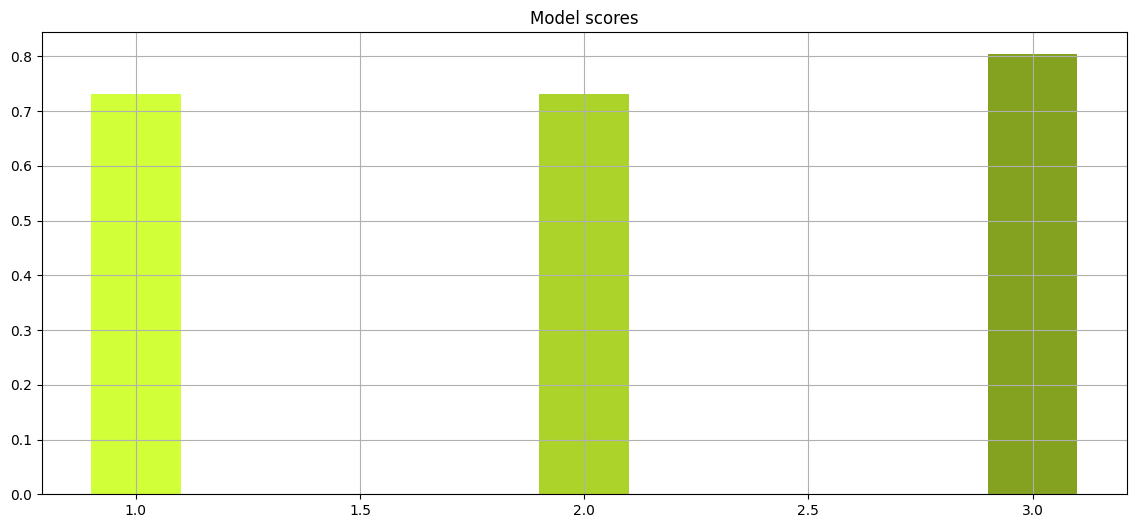

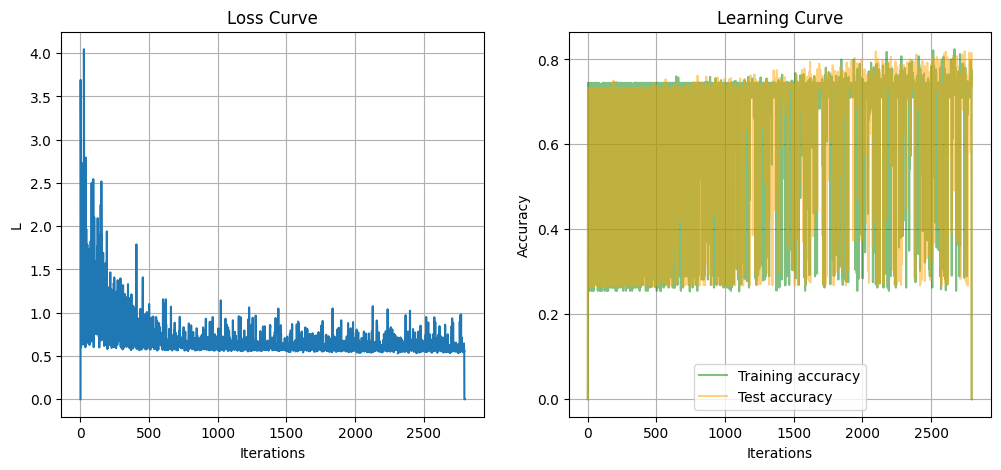

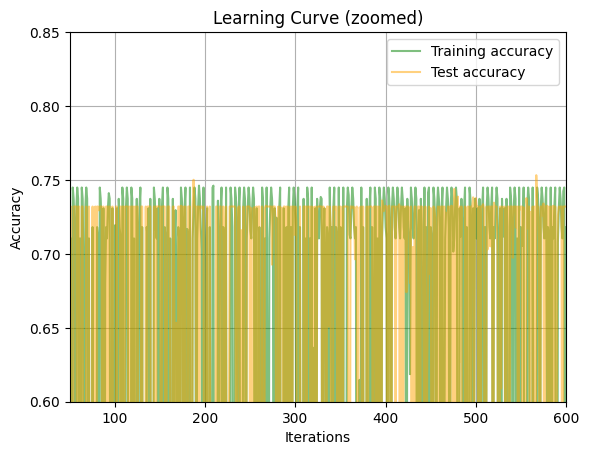

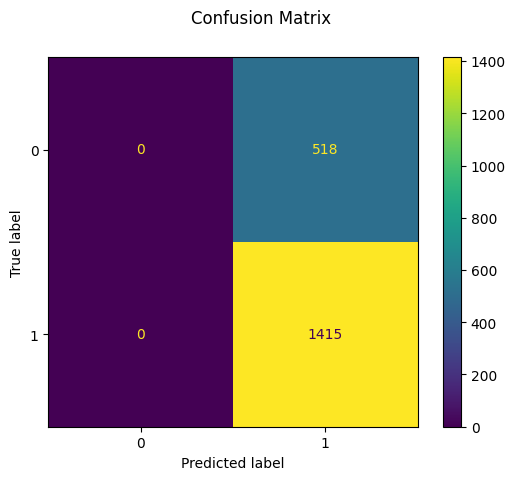

(2, 440)


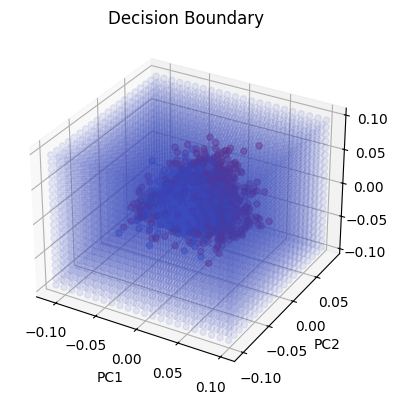

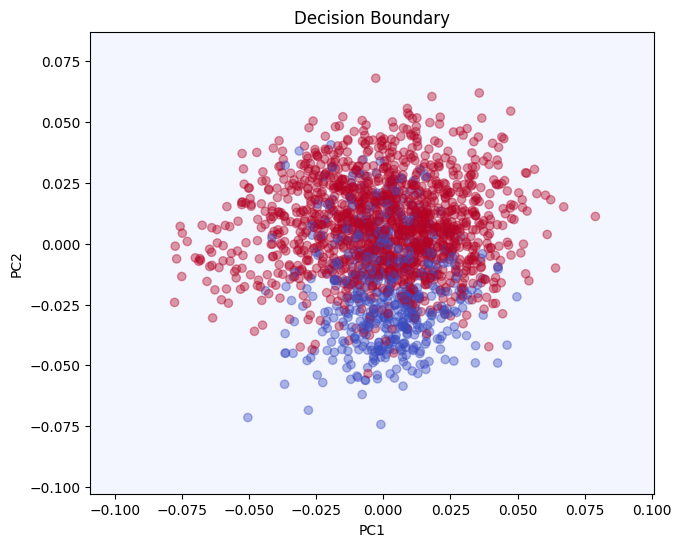

In [42]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))
plotDecisionBoundaries(model, X_test_pca, y_test_simpler_reshaped, precision=0.01, overlap=0.2, true_op=0.4, boundary_op=0.1)

In [9]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('MinMaxScaler', MinMaxScaler())])

X_train_pca = pipeline.fit_transform(X_train_pca)
X_test_pca = pipeline.fit_transform(X_test_pca)

In [10]:
layers = [
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DenseGpuLayer(ReluGpuActivation(), HeGpuInitializer(), 64),
    DenseGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(), 64),
    DropoutGpuLayer(),
    DenseGpuLayer(ReluGpuActivation(), HeGpuInitializer(), 64),
    OutputGpuLayer(SigmoidGpuActivation(), RandomGpuInitializer(),  2)
]

model = lmnn(layers, BceGpuLoss(), n_iter=2800, lr=0.019, patience=1800, strategy="sub", sub_parts=5)

model.fit(X_train_pca, X_test_pca, y_train_simpler_reshaped, y_test_simpler_reshaped)

100%|██████████| 559/559 [00:20<00:00, 27.43it/s]


In [11]:
y_pred = model.predict(X_test_pca)

Least accuracy :0.91722710812209
Least recall :0.91722710812209
Least precision :0.9217774888999276


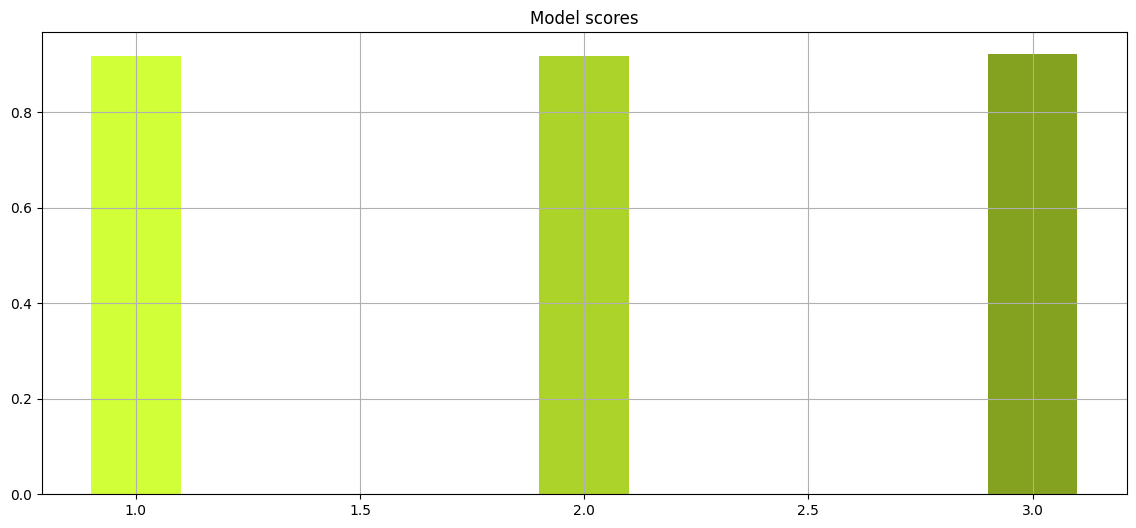

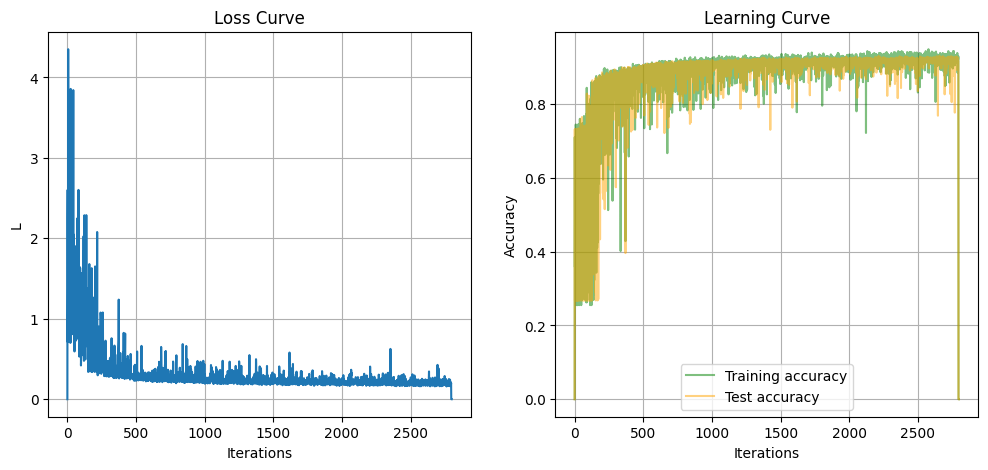

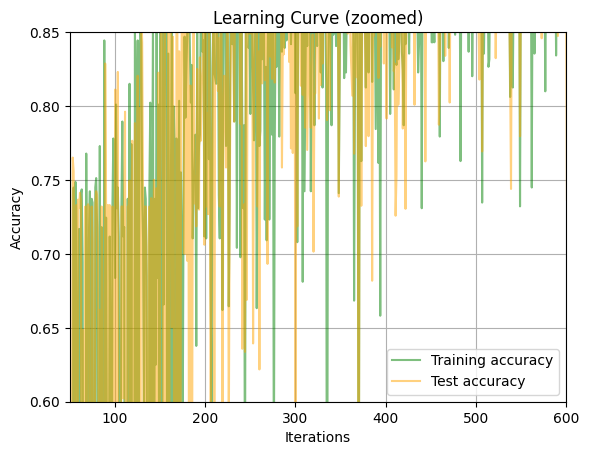

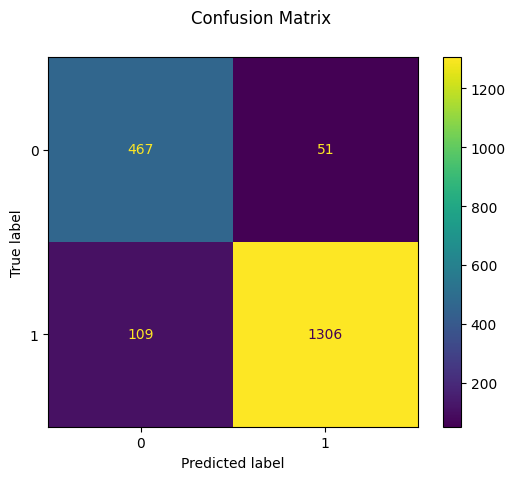

(array([0, 1], dtype=int64), array([   4, 3371], dtype=int64))
(array([1], dtype=int64), array([225], dtype=int64))
(2, 225)


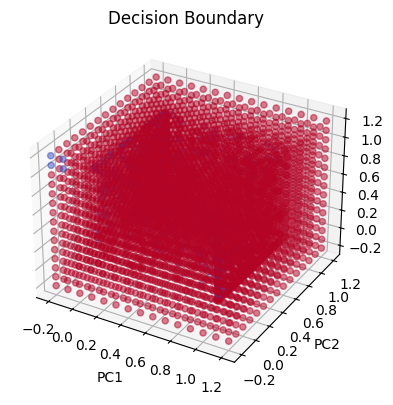

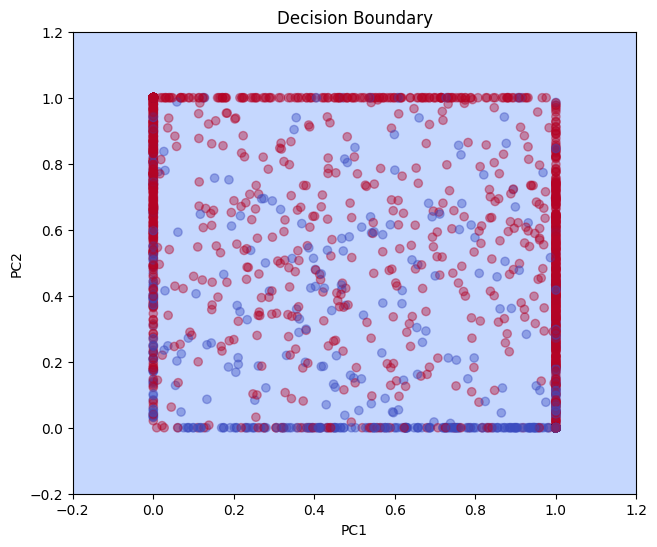

In [16]:
plotHist(model.training_history.get(), y_test_simpler_reshaped,y_pred.get(), zoomx=(50,600), zoomy=(0.6,0.85))
plotDecisionBoundaries(model, X_test_pca, y_test_simpler_reshaped, precision=0.1, overlap=0.2, true_op=0.4, boundary_op=0.5)